In [1]:
import pyterrier as pt
import pandas as pd
from pyterrier.measures import RR, nDCG, MAP

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [2]:
dataset_path = "irds:beir/fiqa"
dataset = pt.get_dataset(dataset_path)
testset = pt.get_dataset(dataset_path + "/test")

In [3]:
# Indexing documents
from pathlib import Path

indexer = pt.IterDictIndexer(
    str(Path.cwd()),  # this will be ignored
    type=pt.index.IndexingType.MEMORY,
)
index_ref = indexer.index(dataset.get_corpus_iter())

Java started (triggered by TerrierIndexer.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
beir/fiqa documents: 100%|██████████| 57638/57638 [00:10<00:00, 5453.55it/s]


In [4]:
# Add noise to the queries

# Retrieve test queries
test_queries = testset.get_topics()

# Add noise by deleting characters 10% of the time
aug = nac.OcrAug(aug_char_p=0.25, aug_word_p=0.7)

# Apply noise to queries
noisy_queries_list = []
for _, row in test_queries.iterrows():
    noisy_query = aug.augment(row['query'])

    if isinstance(noisy_query, list):
        noisy_query = " ".join(noisy_query)

    noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

noisy_queries_df = pd.DataFrame(noisy_queries_list)
noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

print("Original Query:", test_queries.iloc[0]['query'])
print("Noisy Query:", noisy_queries_df.iloc[0]['query'])

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
dir = pt.terrier.Retriever(index_ref, wmodel="DirichletLM")
pl2 = pt.terrier.Retriever(index_ref, wmodel="PL2")
dfree = pt.terrier.Retriever(index_ref, wmodel="DFReeKLIM")


# Run the experiment
pt.Experiment(
    [bm25, dfree, pl2, dir],
    noisy_queries_df,
    testset.get_qrels(),
    eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100],
)

Original Query: where should i park my rainy day emergency fund
Noisy Query: wheke sh0u1d i pakr my rainy day emergency fond
18:45:00.347 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:45:08.916 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:45:16.769 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:45:24.828 [main] WARN o

,name,RR@10,nDCG@10,AP@100
0,TerrierRetr(BM25),0.090946,0.078032,0.064412
1,TerrierRetr(DFReeKLIM),0.098859,0.084799,0.070316
2,TerrierRetr(PL2),0.089697,0.077042,0.063110
3,TerrierRetr(DirichletLM),0.056608,0.053534,0.042205


In [5]:
testset = pt.get_dataset("irds:beir/fiqa/test")
test_queries = testset.get_topics()

# Define noise levels
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

bm25 = pt.terrier.Retriever(index_ref, wmodel="BM25")
dir = pt.terrier.Retriever(index_ref, wmodel="DirichletLM")
pl2 = pt.terrier.Retriever(index_ref, wmodel="PL2")
dfree = pt.terrier.Retriever(index_ref, wmodel="DFReeKLIM")

results = []

for noise_level in noise_levels:

    aug = nac.OcrAug(aug_char_p=0.25, aug_word_p=noise_level, aug_word_min=0, aug_word_max=500000)

    # Apply noise to queries
    noisy_queries_list = []
    for _, row in test_queries.iterrows():
        noisy_query = aug.augment(row['query'])
        if isinstance(noisy_query, list):
            noisy_query = " ".join(noisy_query)
        noisy_queries_list.append({'qid': row['qid'], 'query': noisy_query})

    noisy_queries_df = pd.DataFrame(noisy_queries_list)
    noisy_queries_df["qid"] = noisy_queries_df["qid"].astype(str)

    print("Original query:", test_queries.iloc[0]['query'])
    print("Noisy query:", noisy_queries_df.iloc[0]['query'])

    # Run retrieval experiment
    eval_result = pt.Experiment(
        [bm25, dfree, pl2, dir],
        noisy_queries_df,
        testset.get_qrels(),
        eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
    )

    # Store results
    eval_result["noise_level"] = noise_level
    results.append(eval_result)

# Combine results
final_results = pd.concat(results, ignore_index=True)
print(final_results)

Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emergency fund
18:45:32.911 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:45:42.725 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:45:52.581 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:46:02.349 [main] WARN o

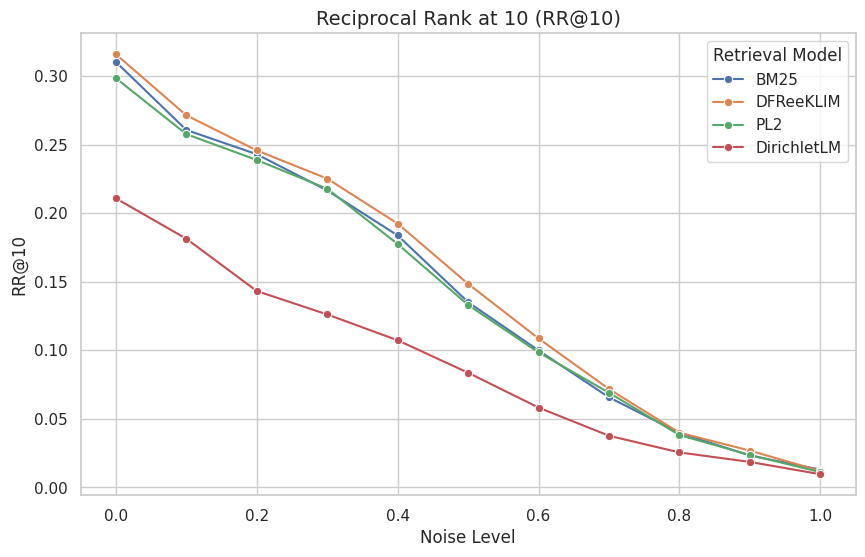

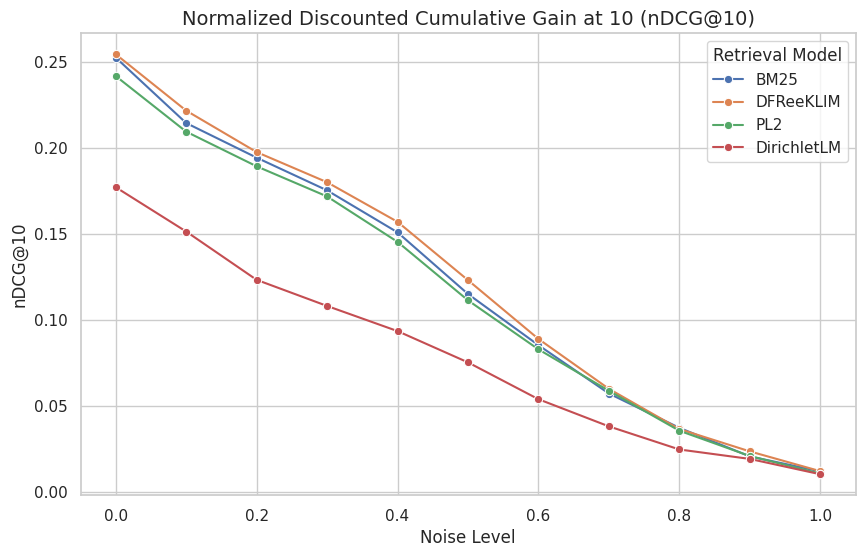

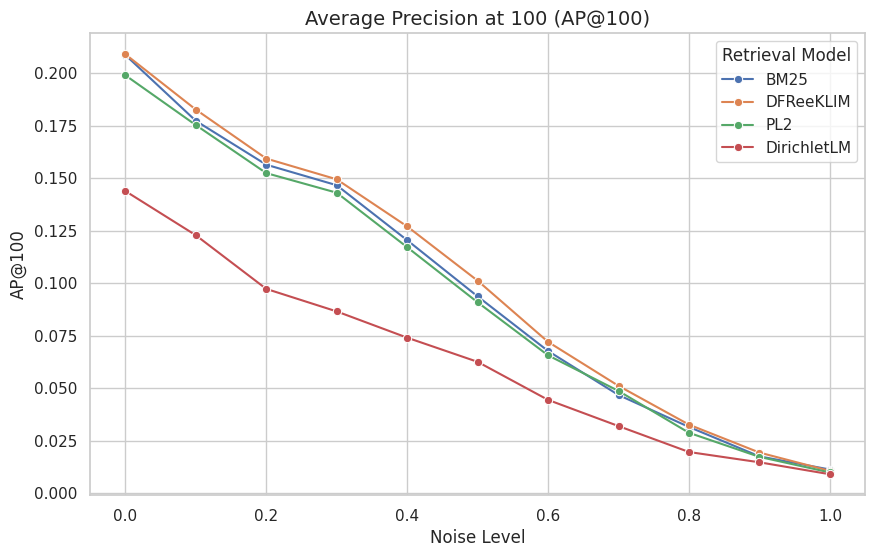

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

final_results["name"] = final_results["name"].str.extract(r"TerrierRetr\((.*?)\)")
sns.set(style="whitegrid")

def plot_metric(metric, title):
    plt.figure(figsize=(10, 6))

    # Plot each retrieval model as a separate line
    sns.lineplot(
        data=final_results,
        x="noise_level",
        y=metric,
        hue="name",
        marker="o",
    )

    plt.title(title, fontsize=14)
    plt.xlabel("Noise Level", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend(title="Retrieval Model")  # Add a legend for models
    plt.show()

# Plot all metrics with model comparison
plot_metric("RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric("nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric("AP@100", "Average Precision at 100 (AP@100)")

In [7]:
testset_2 = pt.get_dataset("irds:beir/fiqa/test")
test_queries_2 = testset_2.get_topics()

# Define noise levels
noise_levels_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

bm25_2 = pt.terrier.Retriever(index_ref, wmodel="BM25")
dir_2 = pt.terrier.Retriever(index_ref, wmodel="DirichletLM")
pl2_2 = pt.terrier.Retriever(index_ref, wmodel="PL2")
dfree_2 = pt.terrier.Retriever(index_ref, wmodel="DFReeKLIM")
results_2 = []

for noise_level in noise_levels_2:

    aug_2 = nac.KeyboardAug(aug_char_p=0.25, aug_word_p=noise_level, include_special_char=False, aug_word_min=0, aug_word_max=500000)

    # Apply noise to queries
    noisy_queries_list_2 = []
    for _, row in test_queries_2.iterrows():
        noisy_query_2 = aug_2.augment(row['query'])
        if isinstance(noisy_query_2, list):
            noisy_query_2 = " ".join(noisy_query_2)
        noisy_queries_list_2.append({'qid': row['qid'], 'query': noisy_query_2})

    noisy_queries_df_2 = pd.DataFrame(noisy_queries_list_2)
    noisy_queries_df_2["qid"] = noisy_queries_df_2["qid"].astype(str)

    print("Original query:", test_queries_2.iloc[0]['query'])
    print("Noisy query:", noisy_queries_df_2.iloc[0]['query'])

    # Run retrieval experiment
    eval_result_2 = pt.Experiment(
        [bm25_2, dfree_2, pl2_2, dir_2],
        noisy_queries_df_2,
        testset_2.get_qrels(),
        eval_metrics=[RR @ 10, nDCG @ 10, MAP @ 100]
    )

    # Store results
    eval_result_2["noise_level"] = noise_level
    results_2.append(eval_result_2)

# Combine results
final_results_2 = pd.concat(results_2, ignore_index=True)
print(final_results_2)

Original query: where should i park my rainy day emergency fund
Noisy query: where should i park my rainy day emergency fund
18:51:32.704 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:51:42.604 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:51:52.515 [main] WARN org.terrier.querying.ApplyTermPipeline -- The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
18:52:02.346 [main] WARN o

                        name     RR@10   nDCG@10    AP@100  noise_level
0          TerrierRetr(BM25)  0.310271  0.252589  0.208640          0.0
1     TerrierRetr(DFReeKLIM)  0.315841  0.254521  0.208981          0.0
2           TerrierRetr(PL2)  0.298390  0.241850  0.198975          0.0
3   TerrierRetr(DirichletLM)  0.210783  0.177237  0.143839          0.0
4          TerrierRetr(BM25)  0.256078  0.208560  0.170676          0.1
5     TerrierRetr(DFReeKLIM)  0.258134  0.209059  0.172069          0.1
6           TerrierRetr(PL2)  0.246618  0.199796  0.163700          0.1
7   TerrierRetr(DirichletLM)  0.170514  0.139449  0.113146          0.1
8          TerrierRetr(BM25)  0.215026  0.177849  0.145353          0.2
9     TerrierRetr(DFReeKLIM)  0.222730  0.177094  0.146699          0.2
10          TerrierRetr(PL2)  0.206880  0.171305  0.138115          0.2
11  TerrierRetr(DirichletLM)  0.147334  0.121088  0.099483          0.2
12         TerrierRetr(BM25)  0.152221  0.129273  0.103322      

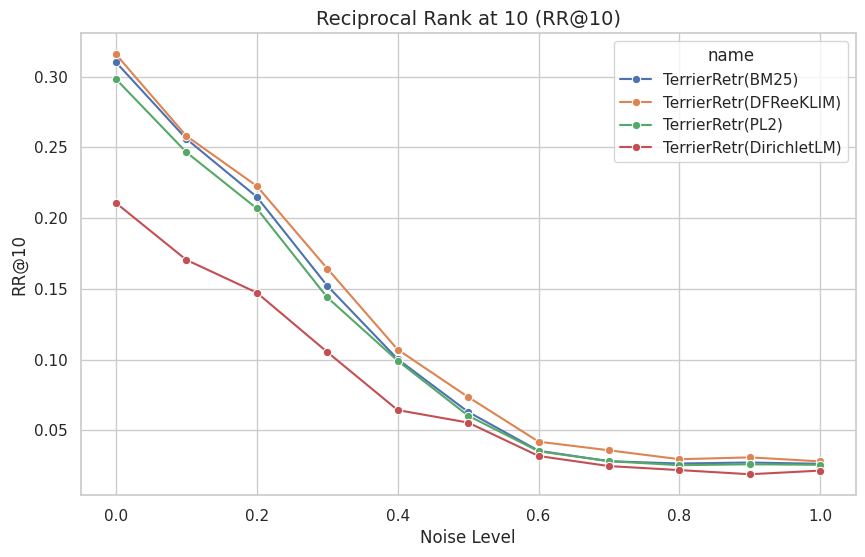

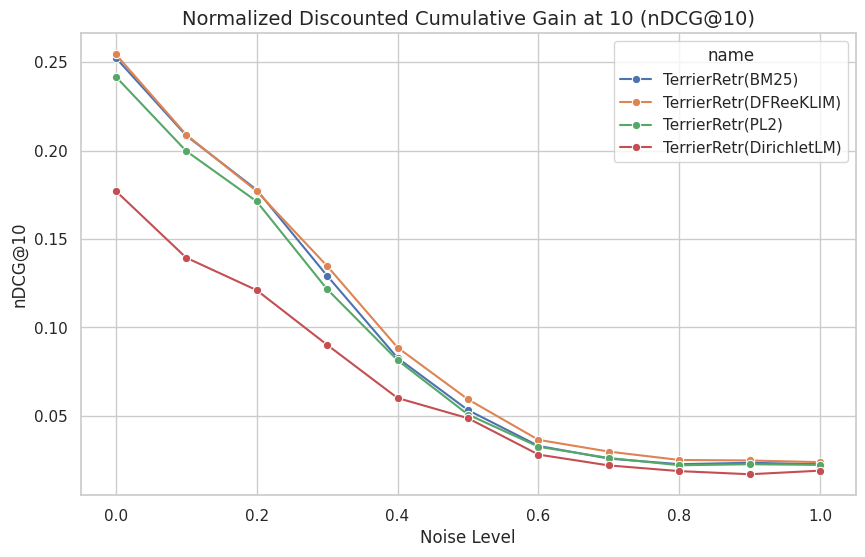

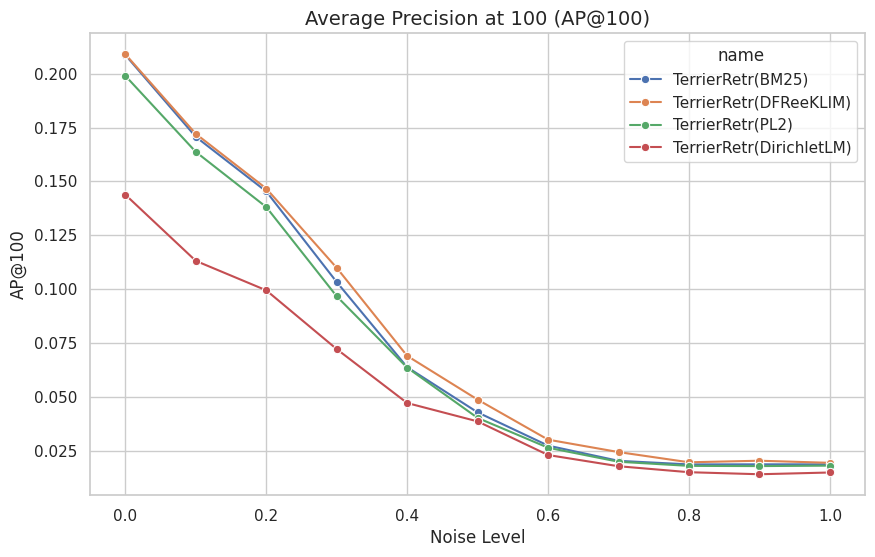

In [8]:
sns.set(style="whitegrid")
print(final_results_2)

# final_results_2["name"] = final_results_2["name"].str.extract(r"TerrierRetr\((.*?)\)")

def plot_metric_2(metric, title):
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=final_results_2,
        x="noise_level",
        y=metric,
        hue="name",
        marker="o",
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Noise Level", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.show()

plot_metric_2("RR@10", "Reciprocal Rank at 10 (RR@10)")
plot_metric_2("nDCG@10", "Normalized Discounted Cumulative Gain at 10 (nDCG@10)")
plot_metric_2("AP@100", "Average Precision at 100 (AP@100)")